# APE_NEG analysis

### 0) Library upload

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import scipy as sp
import csv
import scanpy as sc

import copy
import re
from collections import Counter
from igraph import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf
import keras
import desc

In [30]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [31]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.2


In [32]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

### 1) Import data

In [33]:
adata = sc.read_10x_mtx("/home/spuccio/homeserver2/SP018_Pelosi/Lib_APE-NEG/outs/filtered_feature_bc_matrix",var_names='gene_symbols',make_unique=True,)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [34]:
adata.shape

(6669, 33538)

### APE_POS has 6669 cells detected from CELL-Ranger 

In [35]:
adata.layers['UMIs'] = adata.X.copy()

In [36]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')

In [37]:
sc.pp.calculate_qc_metrics(adata,qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [38]:
adata = adata[:,adata.X.sum(axis=0) > 0]

In [39]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

In [40]:
# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 1.0  -  1034280.0
Number of cells in which each gene is detected: 1  -  6668


### 2) Filtering low expressed genes

In [41]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)
#
adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [42]:
adata.shape

(6669, 20263)

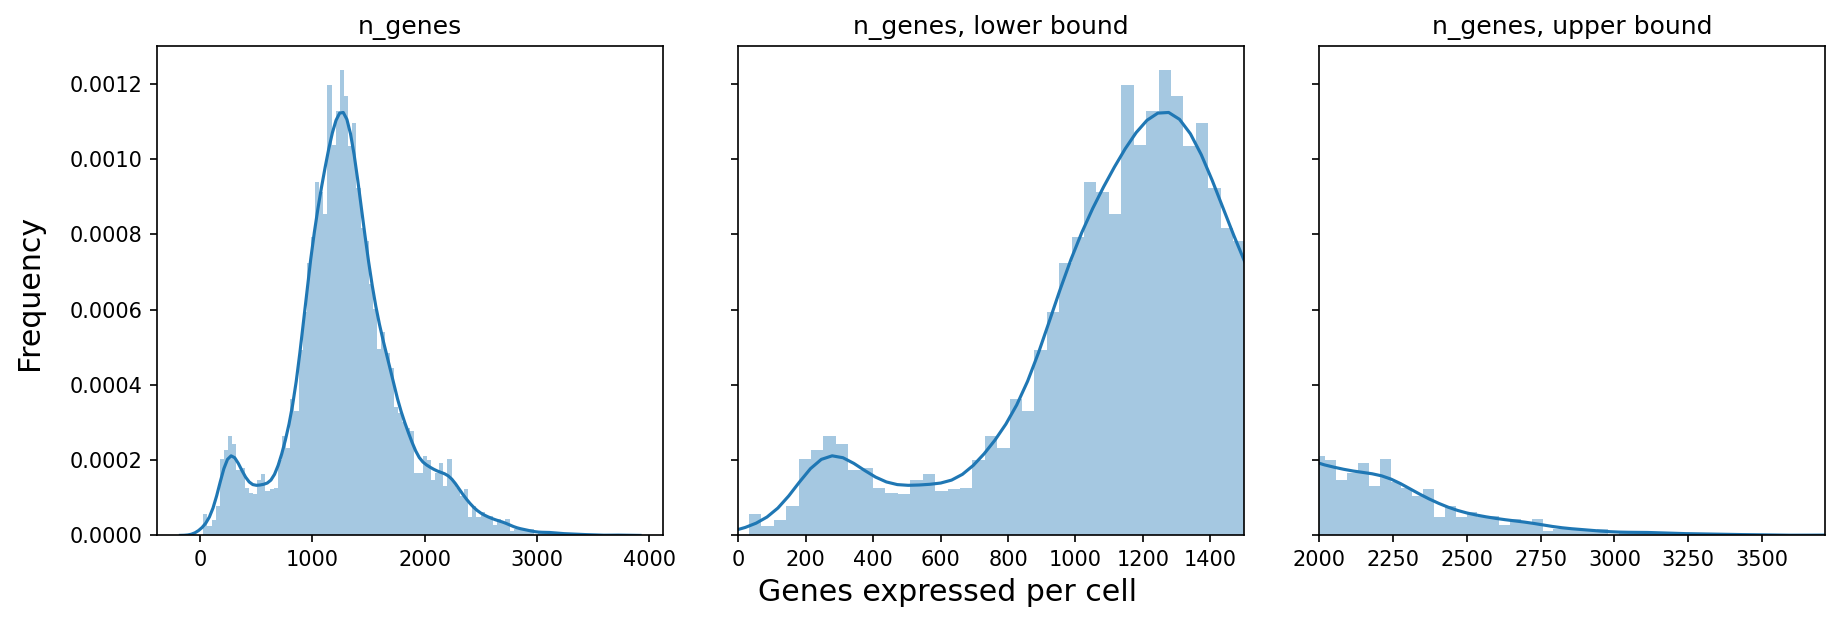

In [43]:
import seaborn as sns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

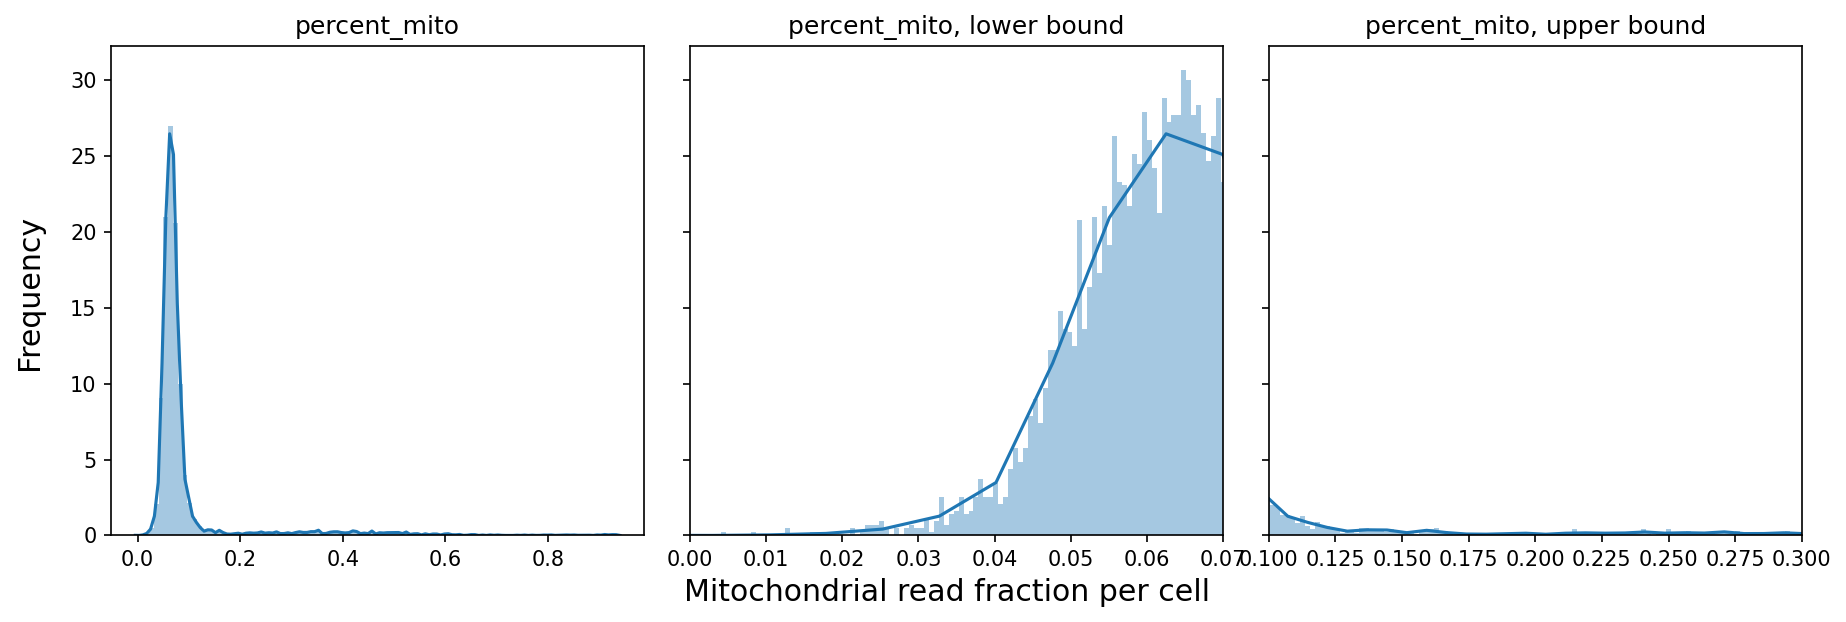

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

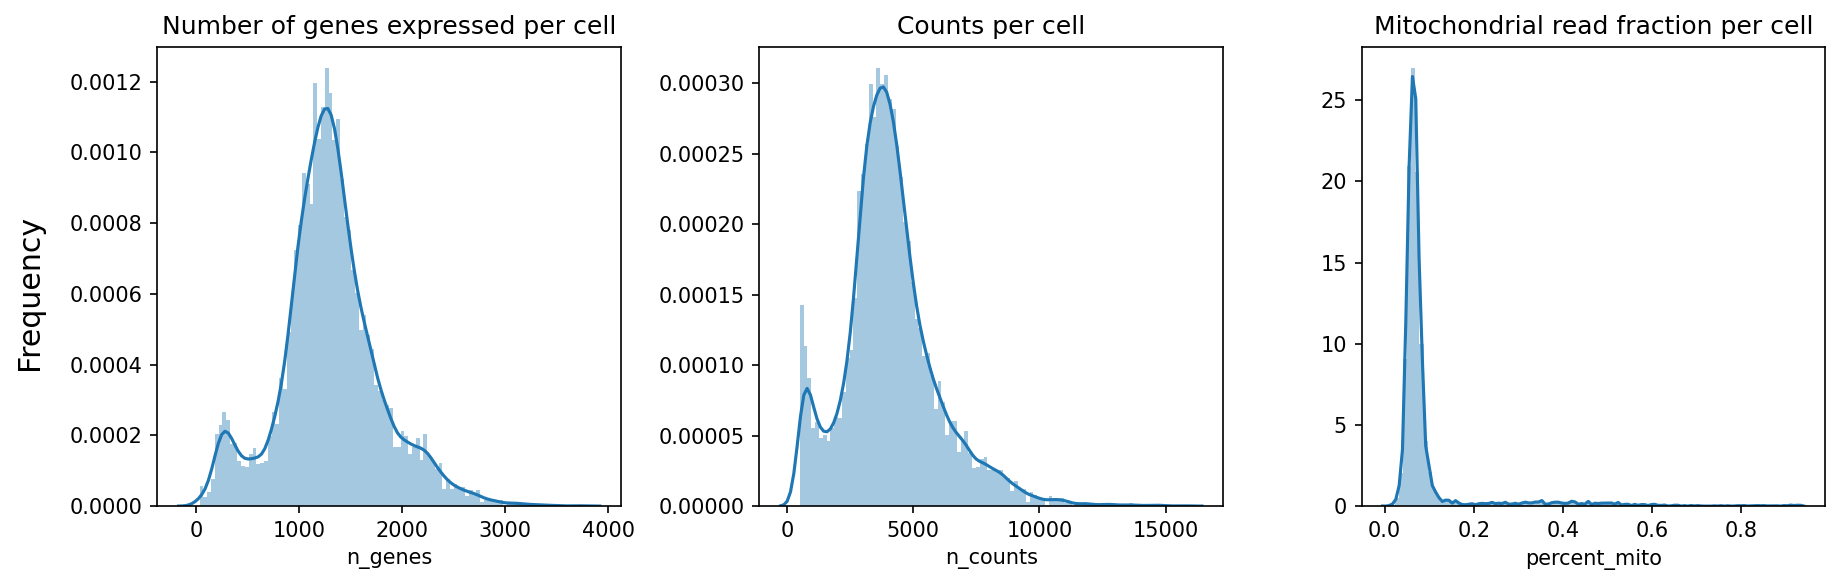

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

#fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

In [46]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 75 cells that have less than 200 genes expressed
filtered out 3145 genes that are detected in less than 3 cells


In [47]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith("MT-")

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)


6594 17104


In [48]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith("MT")

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)


6594 17031


In [49]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith("RB")

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)


6594 16959


In [50]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith("RPS")

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

6594 16913


In [51]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith("RPL")

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

6594 16858


### 3) Normalization and Logarithm transformation 

In [52]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [53]:
adata.raw=adata

### 4) Selection of highly variable genes

In [54]:
plt.rcParams['figure.figsize'] = [12, 6]

# Select and plot genes that have high dispersion (>0.5) and mean expression (>0.0125)
# This selection is similar to "mean.var.plot" feature selection called with
# the FindVariableFeatures function in Seurat
# Note how the highly_variable_genes() function in scanpy's preprocessing (pp) library
# has a matching function with its plotting (pl) library
sc.pp.highly_variable_genes(adata,flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


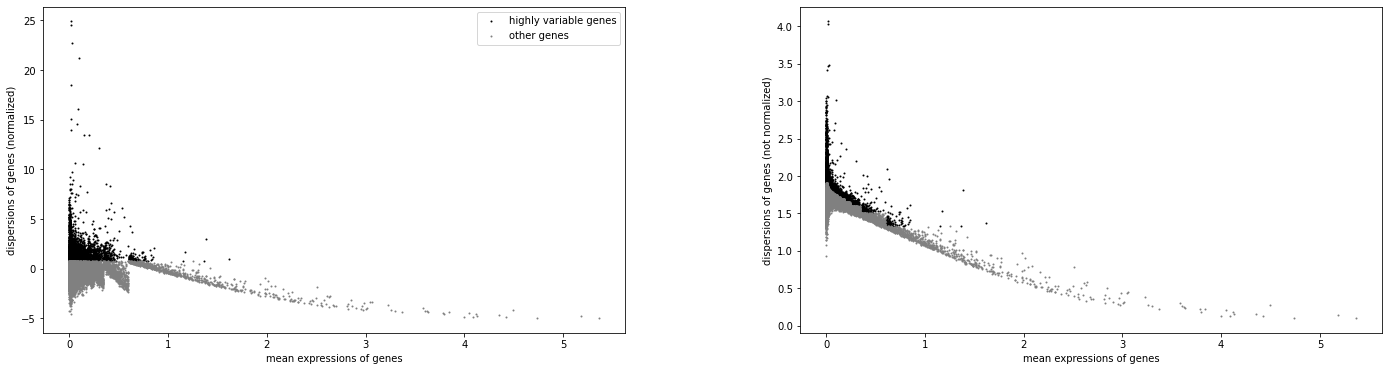

In [55]:
sc.pl.highly_variable_genes(adata)

### 5) Scaling

In [56]:
desc.scale(adata, zero_center=True, max_value=6)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### 6) Visualization

In [57]:
# Run principle component analysis
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [58]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


... storing 'feature_types' as categorical


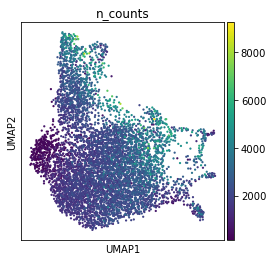

In [59]:
plt.rcParams['figure.figsize']=(4,4)
#sc.pl.pca_scatter(adata, color='n_counts',s=20)
sc.pl.umap(adata, color='n_counts',s=20)

In [ ]:
adata=desc.train(adata,
        dims=[adata.shape[1],64,32],
        tol=0.005,
        n_neighbors=15,
        batch_size=256,
        louvain_resolution=[0.3,0.4,0.5,0.6,0.7,0.8],# not necessarily a list, you can only set one value, like, louvain_resolution=1.0
        do_tsne=False,
        learning_rate=200, # the parameter of tsne
        use_GPU=False,
        num_Cores=1, #for reproducible, only use 1 cpu
        num_Cores_tsne=30,
        save_encoder_weights=False,
        save_encoder_step=3,# save_encoder_weights is False, this parameter is not used
        use_ae_weights=False,
        do_umap=True,
        verbose=False)

In [61]:
#data_clus = adata.obs[['louvain_r9_clusters','louvain_r8_clusters','louvain_r7_clusters','louvain_r6_clusters','louvain_r5_clusters','louvain_r4_clusters','louvain_r3_clusters','louvain_r1_clusters']]

In [62]:
data_clus = adata.obs[['desc_0.6','desc_0.3','desc_0.4','desc_0.5','desc_0.7','desc_0.8']]

In [63]:
data_clus.columns = ['louvain_r6_clusters','louvain_r3_clusters','louvain_r4_clusters','louvain_r5_clusters','louvain_r7_clusters','louvain_r8_clusters']

In [64]:
data_clus.to_csv("/home/spuccio/homeserver2/SP018_Pelosi/APE_neg_analysis/temp.csv",index=True,header=True)

In [65]:
data_clus = pd.read_csv("/home/spuccio/homeserver2/SP018_Pelosi/APE_neg_analysis/temp.csv",index_col=0,header=0)

In [66]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

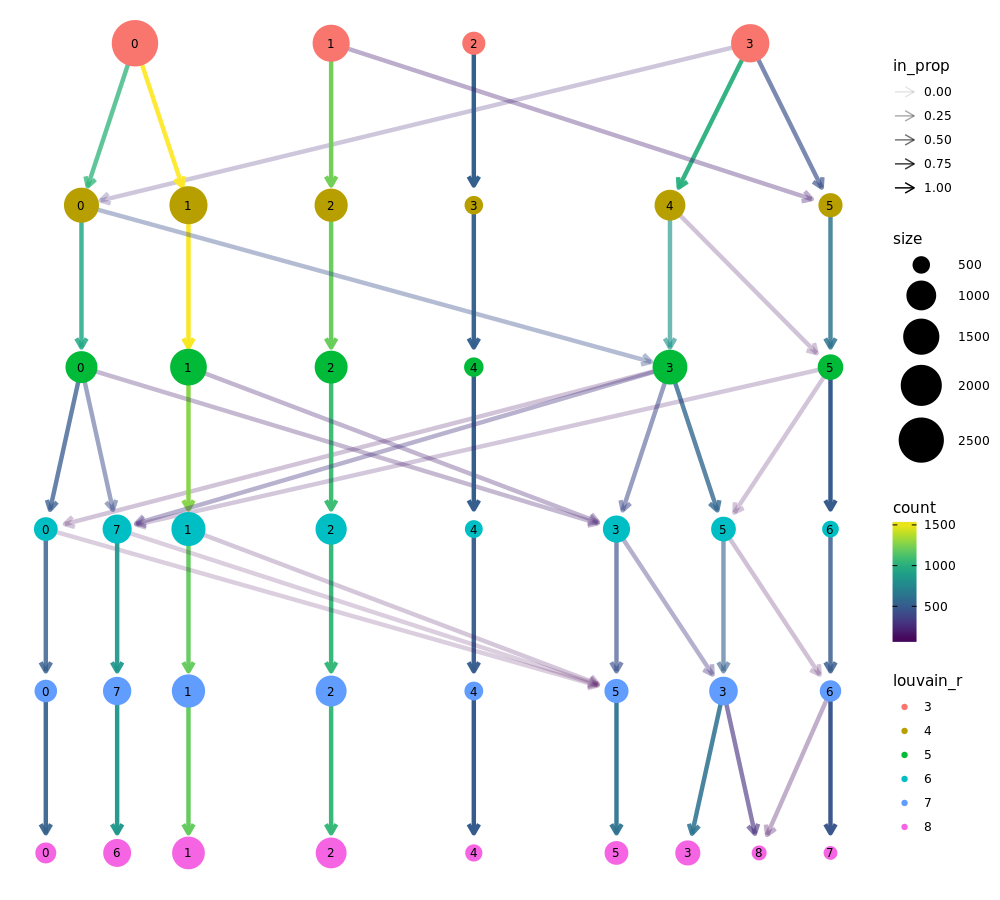

In [67]:
%%R -i data_clus
library(clustree)

clustree(data_clus,prefix="louvain_r",suffix = "_clusters") 

In [68]:
adata.obs['desc_0.7'].value_counts()

1    1249
2    1074
3     926
7     908
5     691
0     630
6     593
4     523
Name: desc_0.7, dtype: int64

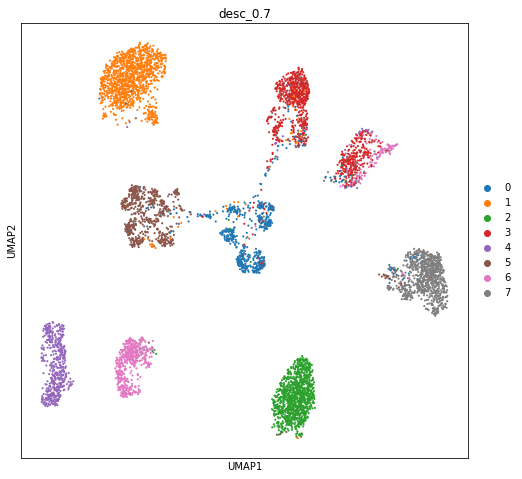

In [69]:
plt.rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata, color='desc_0.7')

In [70]:
#sc.pp.scale(adata,max_value=10)
sc.tl.rank_genes_groups(adata, 'desc_0.7', method='t-test', key_added = "t-test",use_raw=True)

ranking genes
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [71]:
pd.DataFrame(adata.uns['t-test']['names']).head(20)

,0,1,2,3,4,5,6,7
0,TMSB4X,TPT1,FCER1A,IGHM,XIST,TPT1,H2AFZ,CD99
1,SERPINB1,AVP,AL157895.1,TMSB4X,NEAT1,AVP,TUBA1B,ANXA1
2,RACK1,HIST1H1C,FTH1,CD99,CCNL1,HINT1,STMN1,TKT
3,ACTG1,NACA,EREG,ITM2C,SQSTM1,HLA-DRA,YBX1,SERPINB1
4,BTF3,EIF1,PTMA,ACTG1,LENG8,NACA,PTMA,GAPDH
5,TPT1,EEF1A1,CTNNBL1,FAM30A,SREBF1,AC011139.1,PPIA,NAP1L1
6,GAPDH,JUND,AC084033.3,MZB1,FLNA,EEF1A1,TYMS,ACTG1
7,SPINK2,FAU,SERPINB1,KLF6,MAPK8IP3,BTF3,DUT,VIM
8,HINT1,FTH1,SOX4,VIM,GLS,HLA-DRB5,GAPDH,TMSB4X
9,CD69,FTL,HSP90AB1,TMSB10,NFATC2IP,HLA-E,ACTB,SPINK2


In [72]:
sc.tl.dendrogram(adata,groupby="desc_0.7")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['desc_0.7']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_desc_0.7']`


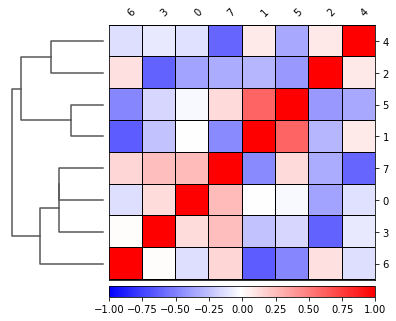

In [73]:
sc.pl.correlation_matrix(adata,'desc_0.7')

In [74]:
result = adata.uns['t-test']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(300).to_csv("/home/spuccio/homeserver2/SP018_Pelosi/APE_neg_analysis/DEGS_Louvain_clustering.tsv",sep="\t",header=True,index=False)

In [75]:
adata.write('/home/spuccio/homeserver2/SP018_Pelosi/APE_neg_analysis/adata.h5ad')

... storing 'feature_types' as categorical
